# Assignment 1
## Setup

In [239]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from types import SimpleNamespace
from consav.linear_interp import interp_2d

# load local model file and initialize model class
from DynLaborFertModel import DynLaborFertModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Question 1

In [240]:
#Initialize model bank
#modelbank = {}

In [241]:
for id in range(53,54):
    modelbank[id] = {}
    b1 = id / 1000
    modelbank[id]['baseline'] = model = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3, 'beta_1': b1})
    model.solve()
    model.simulate()

In [242]:
for id in range(53,54):
    response = np.mean(modelbank[id]['baseline'].sim.h[modelbank[id]['baseline'].sim.time_since_birth==0])/np.mean(modelbank[id]['baseline'].sim.h[modelbank[id]['baseline'].sim.time_since_birth==-1]) -1
    print(f'beta_1 = {modelbank[id]["baseline"].par.beta_1:.3f}', f'avg_response = {response:.2%}')

beta_1 = 0.053 avg_response = -9.56%


In [243]:
#model.plot_behavior()

## Question 2

In [244]:
id = 53
modelbank[id]['tax_increase'] = model = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3, 'beta_1': modelbank[id]['baseline'].par.beta_1, 'tau': 0.1*1.01})
model.solve()
model.simulate()
    

In [245]:
def marshall_long(modelbank, id):
    ''' 
    Calculate and plot Marshall elasticities for a given modelbank and id
    Input: modelbank (dict), id (key of modelbank)
    Output: plot of Marshall elasticities
    '''

    # Unpack
    par = modelbank[id]['baseline'].par
    
    #a. Allocate
    marshall_total   = np.nan + np.zeros(par.T)
    marshall_child   = np.nan + np.zeros(par.T)
    marshall_nochild = np.nan + np.zeros(par.T)

    #b. Calculate
    for t in range(model.par.T):
        #Unpack
        base_h = modelbank[id]['baseline'].sim.h
        shock_h = modelbank[id]['tax_increase'].sim.h
        
        #Conditions (Index of child arrival is identical in baseline and tax_increase model)
        with_child    = modelbank[id]['tax_increase'].sim.n[:,t]>0
        without_child = modelbank[id]['tax_increase'].sim.n[:,t]==0
        
        #Calculate elasticities
        marshall_total[t]   = np.nanmean((shock_h[:,t]             - base_h[:,t])             / base_h[:,t])
        marshall_child[t]   = np.nanmean((shock_h[with_child,t]    - base_h[with_child,t])    / base_h[with_child,t])
        marshall_nochild[t] = np.nanmean((shock_h[without_child,t] - base_h[without_child,t]) / base_h[without_child,t])
      
    #c. Plot  
    fig, ax = plt.subplots()
    ax.plot(range(par.simT),marshall_total*100,label='total')
    ax.plot(range(par.simT),marshall_child*100,label='child')
    ax.plot(range(par.simT),marshall_nochild*100,label='nochild')
    ax.set(xlabel='period, t',ylabel=f'Marshall elasticities',xticks=range(par.simT))
    ax.legend()
    fig.show()
    
def marshall_short(modelbank, id):
    ''' 
    Calculate and plot Marshall elasticities for a given modelbank and id
    Input: modelbank (dict), id (key of modelbank)
    Output: plot of Marshall elasticities
    '''

    # Unpack
    par = modelbank[id]['baseline'].par
    sim_base = modelbank[id]['baseline'].sim
    sol_shock= modelbank[id]['tax_increase'].sol
    
    #1. Allocate
    marshall_total   = np.nan + np.zeros(par.T)
    marshall_child   = np.nan + np.zeros(par.T)
    marshall_nochild = np.nan + np.zeros(par.T)
    
    sim_shock = SimpleNamespace()
    shape = (par.simN,par.simT)
    sim_shock.h = np.nan + np.zeros(shape)


    #2. Calculate        
    # a. loop over individuals and time
    for t in range(par.simT):
        for i in range(par.simN):
            #interpolate optimal consumption and hours
            idx_sol = (t,sim_base.n[i,t], sim_base.s[i,t])
            sim_shock.h[i,t] = interp_2d(par.a_grid,par.k_grid,sol_shock.h[idx_sol],sim_base.a[i,t],sim_base.k[i,t])
        
        #Unpack
        base_h = sim_base.h
        shock_h = sim_shock.h
        
        #Conditions (Index of child arrival is identical in baseline and tax_increase model)
        with_child    = sim_base.n[:,t]>0
        without_child = sim_base.n[:,t]==0
        
        #Calculate elasticities
        marshall_total[t]   = np.nanmean((shock_h[:,t]             - base_h[:,t])             / base_h[:,t])
        marshall_child[t]   = np.nanmean((shock_h[with_child,t]    - base_h[with_child,t])    / base_h[with_child,t])
        marshall_nochild[t] = np.nanmean((shock_h[without_child,t] - base_h[without_child,t]) / base_h[without_child,t])  
            


    #3. Plot  
    fig, ax = plt.subplots()
    ax.plot(range(par.simT),marshall_total*100,label='total')
    ax.plot(range(par.simT),marshall_child*100,label='child')
    ax.plot(range(par.simT),marshall_nochild*100,label='nochild')
    ax.set(xlabel='period, t',ylabel=f'Marshall elasticities',xticks=range(par.simT))
    ax.legend()
    fig.show()

/var/folders/1r/8nkpk12x70q1298b8pv7ghp40000gn/T/ipykernel_88239/1582563716.py:80: RuntimeWarning: Mean of empty slice
  marshall_child[t]   = (np.nanmean(shock_h[with_child,t])    - np.nanmean(base_h[with_child,t]))    / np.nanmean(base_h[with_child,t])
/var/folders/1r/8nkpk12x70q1298b8pv7ghp40000gn/T/ipykernel_88239/1582563716.py:92: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


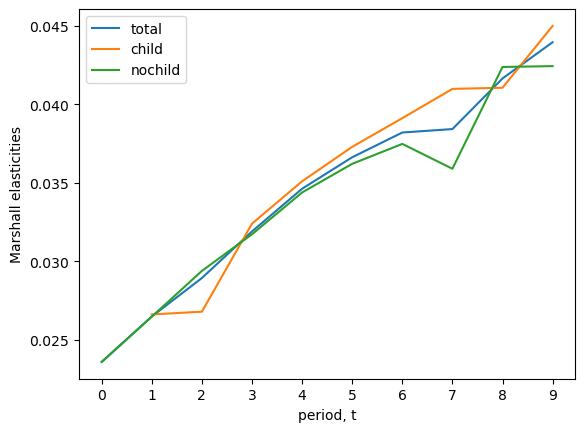

In [246]:
marshall_short(modelbank, id)

/var/folders/1r/8nkpk12x70q1298b8pv7ghp40000gn/T/ipykernel_88239/1582563716.py:28: RuntimeWarning: Mean of empty slice
  marshall_child[t]   = (np.nanmean(shock_h[with_child,t])    - np.nanmean(base_h[with_child,t]))    / np.nanmean(base_h[with_child,t])
/var/folders/1r/8nkpk12x70q1298b8pv7ghp40000gn/T/ipykernel_88239/1582563716.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


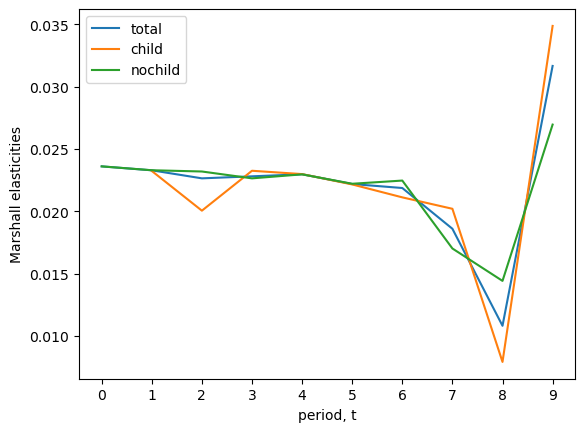

In [247]:
marshall_long(modelbank, id)

# Question 3

In [252]:
modelbank[153] = {}
modelbank[153]['baseline'] = model = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3, 'beta_1': modelbank[53]['baseline'].par.beta_1, 'spouse_base':0.1, 'spouse_time':0.01})
model.solve()
model.simulate()

modelbank[153]['tax_increase'] = model = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3, 'beta_1': modelbank[53]['baseline'].par.beta_1, 'spouse_base':0.1, 'spouse_time':0.01, 'tau': 0.1*1.01})
model.solve()
model.simulate()

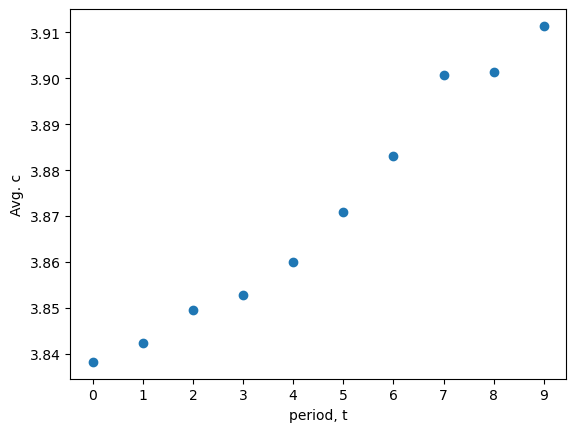

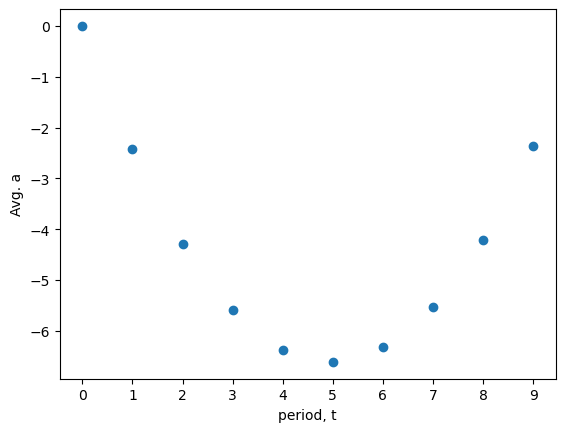

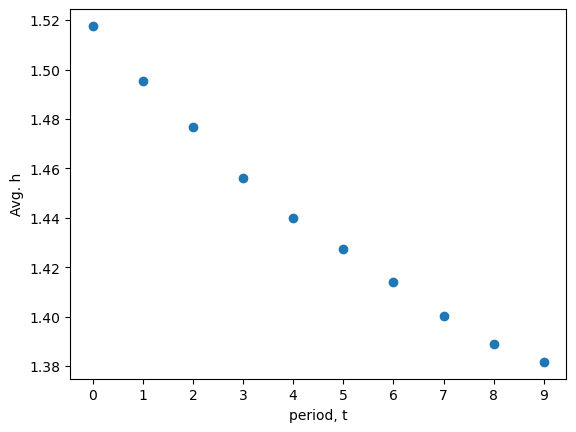

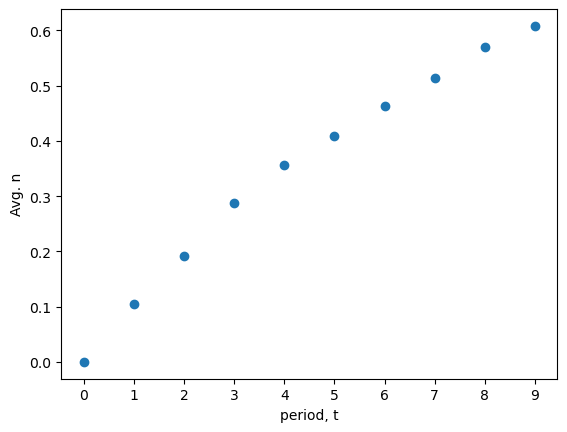

In [256]:
model.plot_behavior()

In [253]:
#print( modelbank[153]['tax_increase'].sol.h / modelbank[153]['baseline'].sol.h)
#print(modelbank[153]['tax_increase'].sim.h.mean(axis=0))
print(np.mean(modelbank[153]['baseline'].par.tau))
print(np.nanmean(modelbank[153]['tax_increase'].par.tau))

0.1
0.101


/var/folders/1r/8nkpk12x70q1298b8pv7ghp40000gn/T/ipykernel_88239/1582563716.py:80: RuntimeWarning: Mean of empty slice
  marshall_child[t]   = (np.nanmean(shock_h[with_child,t])    - np.nanmean(base_h[with_child,t]))    / np.nanmean(base_h[with_child,t])
/var/folders/1r/8nkpk12x70q1298b8pv7ghp40000gn/T/ipykernel_88239/1582563716.py:92: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


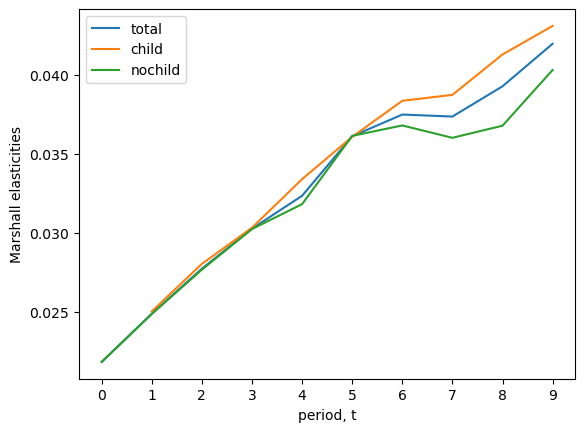

In [254]:
marshall_short(modelbank, 153)

/var/folders/1r/8nkpk12x70q1298b8pv7ghp40000gn/T/ipykernel_88239/1582563716.py:28: RuntimeWarning: Mean of empty slice
  marshall_child[t]   = (np.nanmean(shock_h[with_child,t])    - np.nanmean(base_h[with_child,t]))    / np.nanmean(base_h[with_child,t])
/var/folders/1r/8nkpk12x70q1298b8pv7ghp40000gn/T/ipykernel_88239/1582563716.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


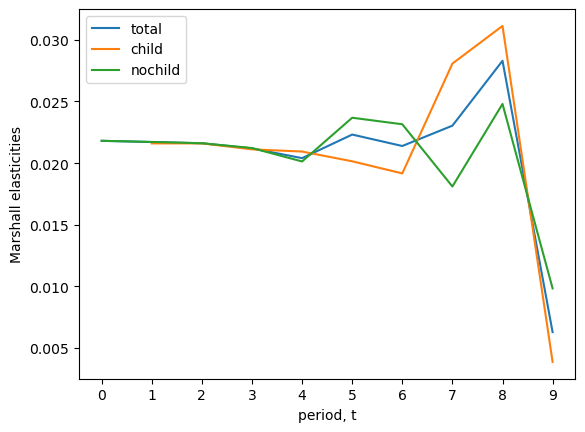

In [255]:
marshall_long(modelbank, 153)

# Question 4

In [208]:
modelbank[5153] = {}
modelbank[5153]['baseline'] = model = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3, 'beta_1': modelbank[53]['baseline'].par.beta_1, 'spouse_base':0.1, 'spouse_time':0.01, 'childcost': 0.05})
model.solve()
model.simulate()

modelbank[5153]['tax_increase'] = model = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3, 'beta_1': modelbank[53]['baseline'].par.beta_1, 'spouse_base':0.1, 'spouse_time':0.01, 'childcost': 0.05, 'tau': 0.1*1.01})
model.solve()
model.simulate()

/var/folders/1r/8nkpk12x70q1298b8pv7ghp40000gn/T/ipykernel_88239/3977448895.py:80: RuntimeWarning: Mean of empty slice
  marshall_child[t]   = (np.nanmean(shock_h[with_child,t])    - np.nanmean(base_h[with_child,t]))    / np.nanmean(base_h[with_child,t])
/var/folders/1r/8nkpk12x70q1298b8pv7ghp40000gn/T/ipykernel_88239/3977448895.py:92: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


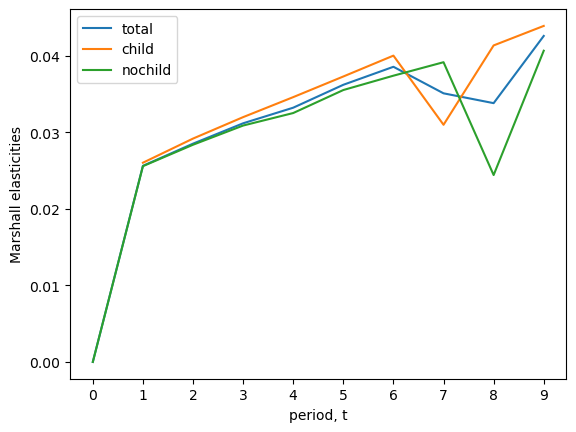

In [210]:
marshall_short(modelbank, 5153)

/var/folders/1r/8nkpk12x70q1298b8pv7ghp40000gn/T/ipykernel_88239/3977448895.py:28: RuntimeWarning: Mean of empty slice
  marshall_child[t]   = (np.nanmean(shock_h[with_child,t])    - np.nanmean(base_h[with_child,t]))    / np.nanmean(base_h[with_child,t])
/var/folders/1r/8nkpk12x70q1298b8pv7ghp40000gn/T/ipykernel_88239/3977448895.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


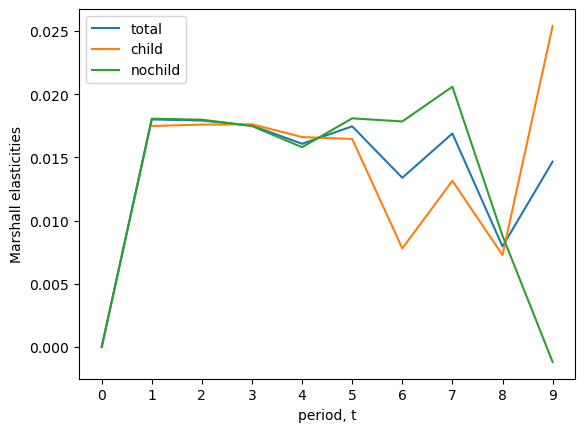

In [211]:
marshall_long(modelbank, 5153)

# Question 5

# Question 6

In [63]:
modelbank[85153] = {}
modelbank[85153]['baseline'] = model = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3, 'beta_1': modelbank[53]['baseline'].par.beta_1, 'spouse_base':0.1, 'spouse_time':0.01, 'childcost': 0.05, 'p_spouse': 0.8})
model.solve()
model.simulate()

modelbank[85153]['tax_increase'] = model = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3, 'beta_1': modelbank[53]['baseline'].par.beta_1, 'spouse_base':0.1, 'spouse_time':0.01, 'childcost': 0.05, 'p_spouse': 0.8, 'tau': 0.1*1.01})
model.solve()
model.simulate()

In [43]:
model.sim.s_initdd

array([0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

/var/folders/1r/8nkpk12x70q1298b8pv7ghp40000gn/T/ipykernel_88239/2255661127.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


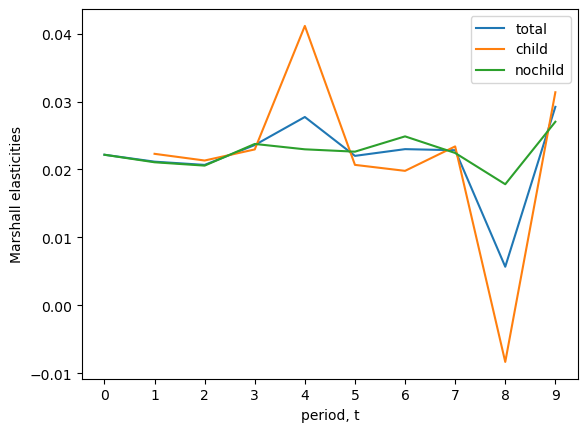

In [64]:
marshall_elasticities(modelbank, 85153)

## Tests

In [141]:
id = 53

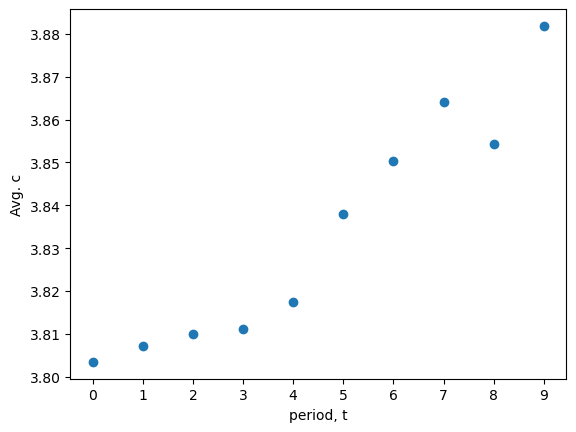

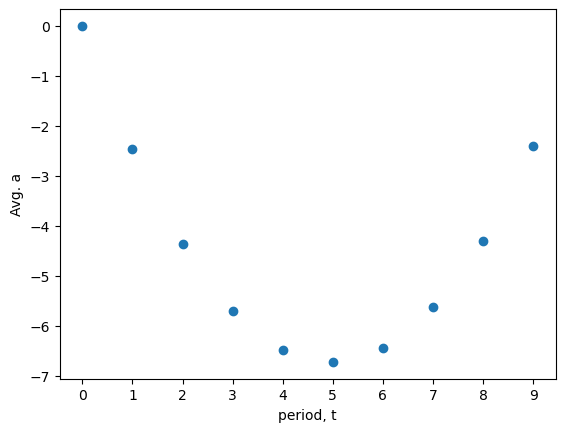

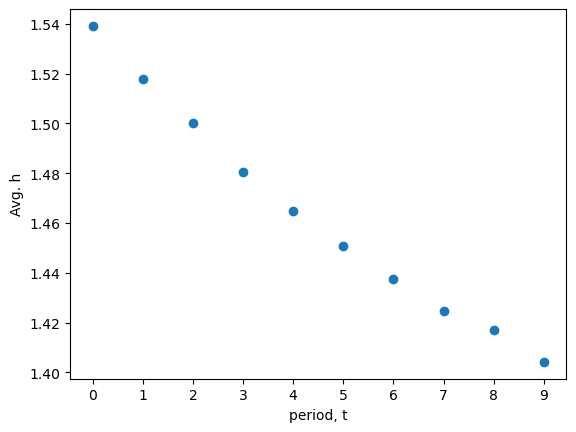

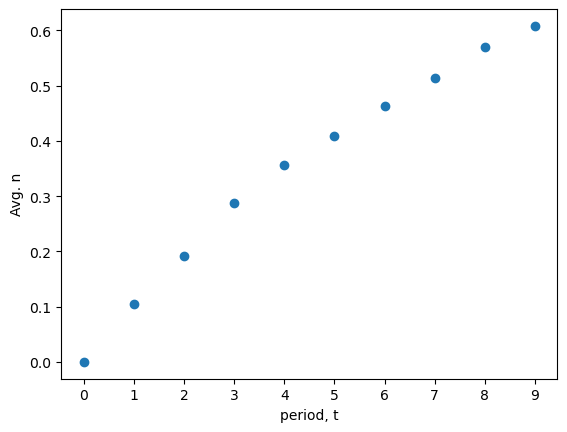

In [30]:
# plot behavior
for var in ('c','a','h','n'):
    fig, ax = plt.subplots()
    ax.scatter(range(par.simT),np.mean(getattr(sim,var),axis=0),label='Simulated')
    ax.set(xlabel='period, t',ylabel=f'Avg. {var}',xticks=range(par.simT))

In [34]:
# birth
birth = np.zeros(sim.n.shape,dtype=np.int_)
birth[:,1:] = (sim.n[:,1:] - sim.n[:,:-1]) > 0

# time since birth
periods = np.tile([t for t in range(par.simT)],(par.simN,1))
time_of_birth = np.max(periods * birth, axis=1)

I = time_of_birth>0
time_of_birth[~I] = -1000 # never has a child
time_of_birth = np.transpose(np.tile(time_of_birth , (par.simT,1)))

time_since_birth = periods - time_of_birth

# calculate average outcome across time since birth
min_time = -8
max_time = 8
event_grid = np.arange(min_time,max_time+1)

event_hours = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours[t] = np.mean(sim.h[time_since_birth==time])

# relative to period before birth
event_hours_rel = event_hours - event_hours[event_grid==-1]

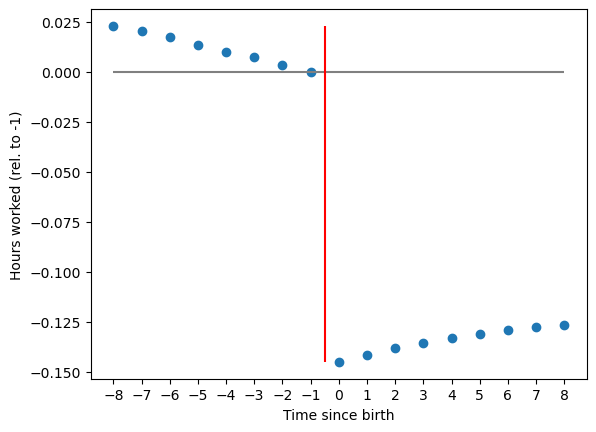

In [32]:
fig, ax = plt.subplots()
ax.scatter(event_grid,event_hours_rel)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel),ymax=np.nanmax(event_hours_rel),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Hours worked (rel. to -1)',xticks=event_grid);